# **EECS 504 PS9: Panoramic Stitching**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Bhushan Ghadge, bghadge

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.


# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_orb_features (1 point)

2. match_keypoints (1 point)

3. find_homography and transform_ransac (1 point each)

4. panoramic_stitching (1 points)

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from scipy.sparse import rand
from scipy import linalg
from google.colab.patches import cv2_imshow

import urllib, os
import scipy.ndimage # For image filtering
from scipy import signal
from scipy import fft
from scipy import fftpack
import imageio # For loading images

In [0]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

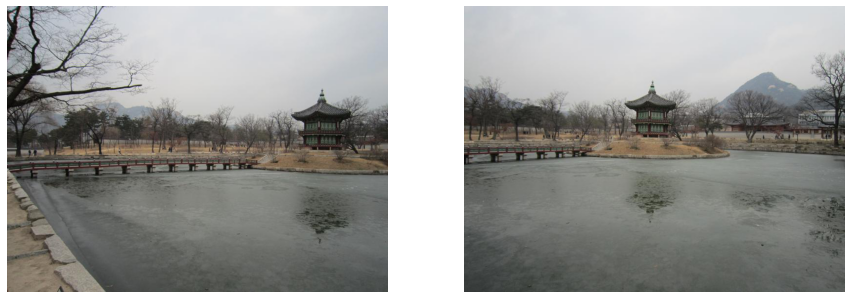

In [0]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for a in ax:
        a.set_axis_off()
    ax[0].imshow(img1)
    ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute ORB Features and Match Keypoints

In [0]:
def get_orb_features(img):
    '''
        Compute ORB features using cv2 library functions. Use default parameters when computing the keypoints.
        Input: 
        img: cv2 image
        Returns:
        keypoints: a list of cv2 keypoints
        descriptors: a list of ORB descriptors
    '''
    # ===============================================
    # TODO
    # Initiate STAR detector
    orb = cv2.ORB_create()

    # Detect and compute the descriptors with ORB
    keypoints, descriptors = orb.detectAndCompute(img,None)

    # ===============================================
    return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
    '''
        Compute matches between feature descriptors of two images using Lowe's ratio test. 
        You may use cv2 library functions.
        Input:
        desc_1, desc_2: list of feature descriptors
        Return:
        matches: list of feature matches
    '''
    # ===============================================
    # TODO
    bf = cv2.BFMatcher()
    matches_ = bf.knnMatch(desc_1,desc_2, k=2)

    # Apply ratio test
    matches = []
    for m,n in matches_:
      if m.distance < ratio * n.distance:
        matches.append(m)
    # ===============================================
    return matches

keypoints for img1 and img2


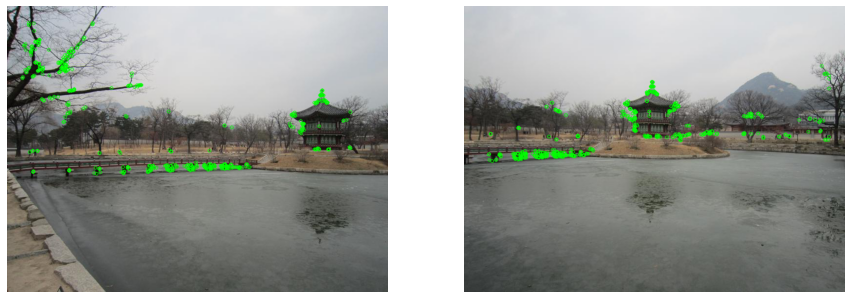

In [0]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


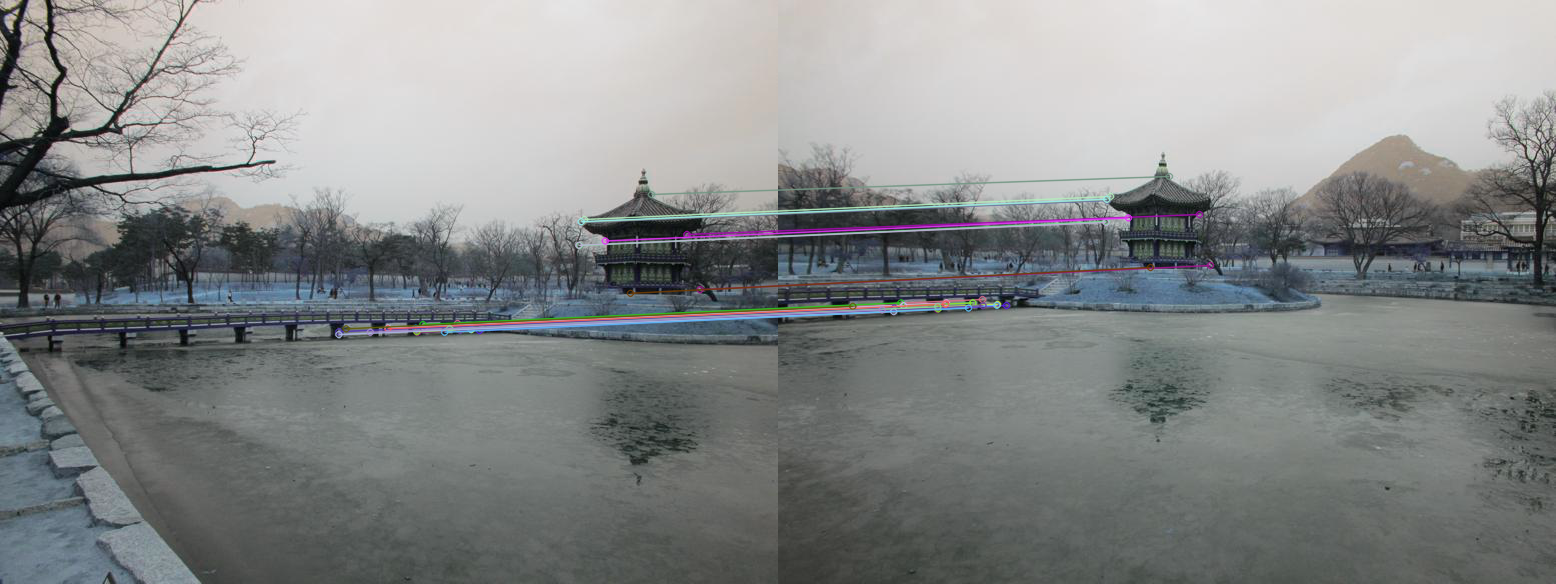

In [0]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:30], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [0]:
def homog(x):
    h,w = x.shape
    if w==2:
        return np.hstack((x, np.ones([h,1])))

def cart(x):
    h,w = x.shape
    if w == 3:
        x = x / (x[:,-1].reshape(-1,1))
        return x[:,0:-1]


In [0]:
def find_homography(pts_1, pts_2):
  '''
    Use either nonlinear least squares or direct linear transform 
    to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Hint: The objective function to optimize here is: ||pts_1 - cart(H*homog(pts_2))||^2 
    where homog(x) converts x into homogeneous coordinates and cart(x) converts x to cartesian coordinates.
    Input:
      pts_1, pts_1: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  # ===============================================
  # TODO

  # Direct Linear Transform
  # print(pts_1.shape)
  # print(pts_2.shape)

  x1 = pts_1[:,0]
  y1 = pts_1[:,1]

  x2 = pts_2[:,0]
  y2 = pts_2[:,1]
  
  a=[]
  for i in range(pts_1.shape[0]):
    a1 = np.array((x1[i], y1[i], 1,   0,      0,     0,  -x1[i]*x2[i],   -y1[i]*x2[i],   -x2[i]))
    a2 = np.array((  0,      0,     0, x1[i], y1[i], 1,  -x1[i]*y2[i],   -y1[i]*y2[i],   -y2[i]))
    a.append(a1)
    a.append(a2)
  
  A = np.matrix(a)
  w,v = np.linalg.eig(A.T @ A)
  idx = np.argmin(w)
  H = v[:,idx]
  H = H * (1.0 / H[-1])
  H = H.reshape(3,3)
  # ===============================================
  return H

In [0]:
def transform_ransac(pts_1, pts_2):
  '''
      Implements RANSAC to estimate homography matrix.
      Input:
      pts_1, pts_1: (N, 2) matrices
      Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  # TODO
  # ===============================================
  
  iterations = 10000
  thresh = 0.1
  max_inliers = -1
  best_model = None
  num_pts = pts_1.shape[0]

  for itr in range(iterations):

      # Random Sampling
      idx = np.random.choice(num_pts, replace=False, size=6)
      p1 = pts_1[idx]
      p2 = pts_2[idx]

      # Model Building
      h = find_homography(p1, p2)

      # Thresholding and Inlier counting
      inliers = 0
      for i in range(num_pts):
          pt1 = homog(pts_1[i,:].reshape(1,-1))
          pt2 = homog(pts_2[i,:].reshape(1,-1))
          error = np.linalg.norm(pt2.T - (h @ pt1.T))
          if error < thresh:
              inliers = inliers + 1

      if inliers > max_inliers:
          max_inliers = inliers
          best_model = h

  # ===============================================
  return best_model

# Panoramic Stitching

In [0]:
def panoramic_stitching(img1, img2):
  '''
      Given a pair of overlapping images, generate a panoramic image. 
      Hint: use the functions that you've written in the previous parts.
      Hint: you may use OpenCV function to apply perspective wrapping.
      Input: 
      img1, img2: cv2 images
      Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  # TODO

  # Generate matching points
  kp1, des1 = get_orb_features(img1)
  kp2, des2 = get_orb_features(img2)

  matches = match_keypoints(des1, des2)

  idx1 = [match.queryIdx for match in matches]    # queryidx for desc_1
  idx2 = [match.trainIdx for match in matches]    # trainidx for desc_2
  
  p1 = []
  p2 = []
  for idx in idx1:
    p1.append(kp_1[idx].pt)
  for idx in idx2:
    p2.append(kp_2[idx].pt)
  
  pts_1 = np.array(p1)
  pts_2 = np.array(p2)

  # Get Homography matrix
  H = transform_ransac(pts_2, pts_1)
  print(H)
  
  # Image stitching
  height = int(img1.shape[0] * 1.1)
  width = int(img1.shape[1] * 1.5)

  warped_img2 = cv2.warpPerspective(img2, H, (width, height))
  (h2,w2,d2) = warped_img2.shape
  (h1,w1,d1) = img1.shape
  
  final_img = np.zeros((h2,w2,d2))
  for i in range(h2):
      for j in range(w2):
          if (np.abs(np.sum(warped_img2[i,j,:])) < 1E-6 ):
              if(i < h1 and j < w1):
                  final_img[i,j,:] = img1[i,j,:]
          else:
              if(i < h1 and j < w1):
                  final_img[i,j,:] = 0.5 * img1[i,j,:] + 0.5 * warped_img2[i,j,:]
              else:
                  final_img[i,j,:] = warped_img2[i,j,:]

  # ===============================================
  return final_img

[[ 6.11402442e-01  7.32671056e-02  2.77775052e+02]
 [-1.63724814e-01  9.15203896e-01  6.04785206e+01]
 [-5.35477104e-04  1.30575198e-04  1.00000000e+00]]


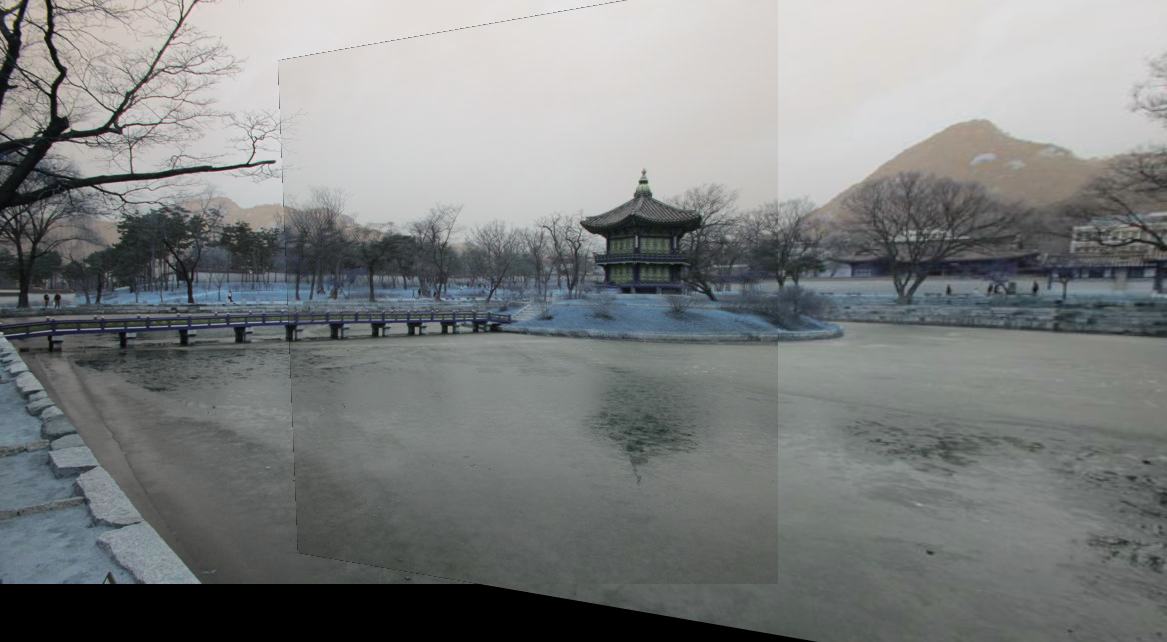

In [0]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)